In [258]:
import torch
import torch.nn as nn
from torch.optim import SGD

import numpy as np
from numpy import exp
from scipy.special import factorial
import matplotlib.pyplot as plt

In [259]:
INPUT_SIZE = 1
HIDDEN_SIZE = 8
NUM_LAYERS = 1
OUTPUT_SIZE = 2

BATCH_SIZE = 10
LEARNING_RATE = 0.1
NUM_EPOCHS = 1000

In [260]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(NeuralNet, self).__init__()
        self.hidden = nn.ModuleList()
        self.input_layer = nn.Linear(input_size, hidden_size)
        for k in range(num_layers-1):
            self.hidden.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x=self.input_layer(x)
        x=x.relu()
        for layer in self.hidden:
            x=layer(x)
            x=x.relu()
        x=self.output_layer(x)
        return x
    
def ReLU_init(model):
    for param in model.parameters():
        nn.init.normal_(param, 0, 1/np.sqrt(HIDDEN_SIZE))

def ReLU_glorot_init(model):
    for name, param in model.named_parameters():
        
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

In [261]:
NUM_SAMPLES = 500
NUM_TRAIN_SAMPLES = 50

X=np.linspace(0,1,NUM_SAMPLES)

breaks=np.sort(np.random.random(2))

encode_inputs=lambda x: 1 if (x>breaks[0] and x<breaks[1]) else 0
Y=np.array([encode_inputs(x) for x in X])

X = torch.from_numpy(X).float()
Y = torch.from_numpy(Y).float()

TRAIN_INDICES = np.random.choice(np.arange(NUM_SAMPLES),size=NUM_TRAIN_SAMPLES,replace=False)
X_TRAIN = X[TRAIN_INDICES]
Y_TRAIN = Y[TRAIN_INDICES]

In [262]:
def get_weight(model):
    weights=[]
    for para in model.parameters():
        weights+=torch.flatten(para).tolist()
    return weights

def next_batch(inputs, targets, batchSize):
    for i in range(0, inputs.shape[0], batchSize):
        yield (inputs[i:i + batchSize], targets[i:i + batchSize])

def get_bound_delta(feature_dataset, label_dataset, feature_train, label_train, deltas, lmdas, delta=0.05, lmda=3, print_loss=False):
    model = NeuralNet(INPUT_SIZE,HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)
    ReLU_init(model)
            
    opt = SGD(model.parameters(), lr=LEARNING_RATE)
    lossFunc = nn.CrossEntropyLoss()

    num_samples=len(feature_dataset)
    num_train=len(feature_train)

    for epoch in range(NUM_EPOCHS):
        for x,y in next_batch(feature_train,label_train,BATCH_SIZE):
            x=x.reshape((len(x),1))
            outputs = model(x)
            loss = lossFunc(outputs, y.long())
            opt.zero_grad()
            loss.backward()
            opt.step()
        if (epoch+1)%100==0 and print_loss:
            print('Epoch {}: Loss {:.3f}'.format(epoch+1,loss.item()))

    model_outputs=model(feature_dataset.reshape(len(feature_dataset),1)).max(1)[1]
    classified=label_dataset==model_outputs

    p_Delta=(sum(classified)/num_samples).numpy()

    train_error=0
    with torch.no_grad():
        for (x,y) in next_batch(feature_train,label_train,5):
            output=model(x.reshape(len(x),1))
            loss = lossFunc(output, y.long())
            train_error+=loss.item()*len(x)
        train_error=train_error/num_train

    true_error=0
    C=0
    with torch.no_grad():
        for (x,y) in next_batch(feature_dataset,label_dataset,1):
            output=model(x.reshape(len(x),1))
            loss = lossFunc(output, y.long())
            if C<loss.item():
                C=loss.item()
            true_error+=loss.item()*len(x)
        true_error=true_error/num_samples

    w=get_weight(model)
    d=len(w)
    pdf = exp(-np.linalg.norm(w)**2/(2*HIDDEN_SIZE))
    pdf = pdf/(2*np.pi*HIDDEN_SIZE)**(d/2)
    pdf=1

    bounds_d=[]
    for de in deltas:
        log_component = p_Delta**num_train
        for k in range(1,num_train):
            log_component+=factorial(num_train)*exp(lmda**2*C**2/(8*k))*p_Delta**(num_train-k)*(1-p_Delta)**k/(factorial(num_train-k)*factorial(k))
        log_component=np.log(log_component)
        bounds_d.append(train_error+(log_component+np.log(1/de)+np.log(1/pdf))/lmda)

    bounds_l=[]
    for lm in lmdas:
        log_component = p_Delta**num_train
        for k in range(1,num_train):
            log_component+=factorial(num_train)*exp(lm**2*C**2/(8*k))*p_Delta**(num_train-k)*(1-p_Delta)**k/(factorial(num_train-k)*factorial(k))
        log_component=np.log(log_component)
        bounds_l.append(train_error+(log_component+np.log(1/delta)+np.log(1/pdf))/lm)
    
    return train_error, true_error, bounds_d, bounds_l, p_Delta

In [263]:
NUM_TESTS=50
DELTAS=[0.01,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.25]
LAMBDAS=np.linspace(2,15,50)
N_DELTA=len(DELTAS)
N_LAMBDA=len(LAMBDAS)

train_errors=[]
test_errors=[]
p_Deltas=[]
trial_bounds_d=[[] for n in range(N_DELTA)]
trial_bounds_l=[[] for n in range(N_LAMBDA)]

for k in range(NUM_TESTS):
    tr_er, ts_er, bs_d, bs_l, p = get_bound_delta(X,Y,X_TRAIN,Y_TRAIN, DELTAS, LAMBDAS)
    train_errors.append(tr_er)
    test_errors.append(ts_er)
    for n, b in enumerate(bs_d):
        trial_bounds_d[n].append(b)
    for n, b in enumerate(bs_l):
        trial_bounds_l[n].append(b)
    p_Deltas.append(p)
    print('Trial {} Training Error {:.3f} Test Error {:.3f}'.format(k+1,tr_er,ts_er))

Trial 1 Training Error 0.067 Test Error 0.089
Trial 2 Training Error 0.045 Test Error 0.062
Trial 3 Training Error 0.045 Test Error 0.063
Trial 4 Training Error 0.068 Test Error 0.089
Trial 5 Training Error 0.054 Test Error 0.075
Trial 6 Training Error 0.067 Test Error 0.088
Trial 7 Training Error 0.045 Test Error 0.062
Trial 8 Training Error 0.046 Test Error 0.063
Trial 9 Training Error 0.057 Test Error 0.076
Trial 10 Training Error 0.070 Test Error 0.092
Trial 11 Training Error 0.046 Test Error 0.063
Trial 12 Training Error 0.050 Test Error 0.068
Trial 13 Training Error 0.059 Test Error 0.080
Trial 14 Training Error 0.069 Test Error 0.091
Trial 15 Training Error 0.057 Test Error 0.078
Trial 16 Training Error 0.055 Test Error 0.076
Trial 17 Training Error 0.046 Test Error 0.063
Trial 18 Training Error 0.071 Test Error 0.093
Trial 19 Training Error 0.067 Test Error 0.088
Trial 20 Training Error 0.070 Test Error 0.091
Trial 21 Training Error 0.513 Test Error 0.531
Trial 22 Training Erro

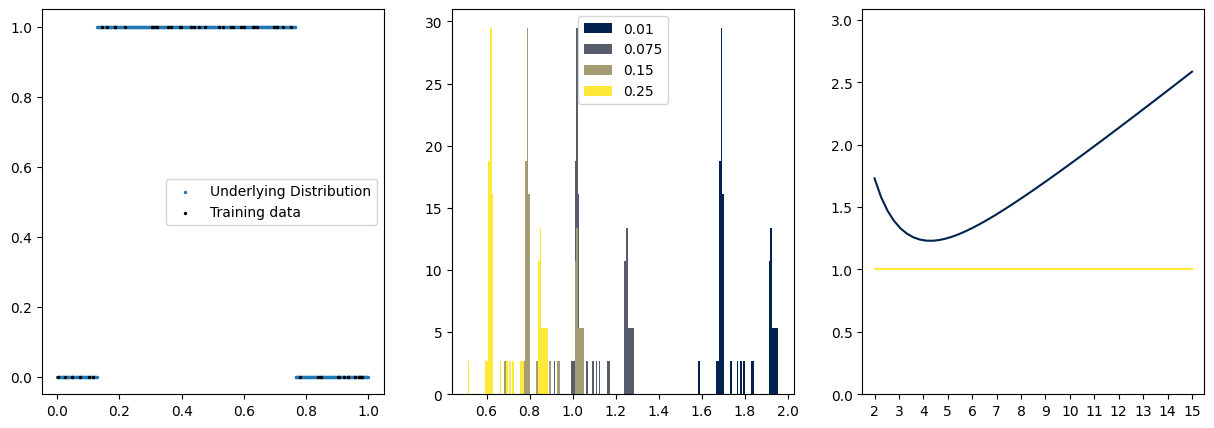

In [265]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

axs[0].scatter(X,Y,s=2,label='Underlying Distribution')
axs[0].scatter(X_TRAIN,Y_TRAIN,c='black',s=2,label='Training data')
axs[0].legend()

colors = plt.cm.cividis(np.linspace(0, 1, N_DELTA))

for m in range(2):
    for n in range(5):
        if (5*m+n)%3==0:
            ts_errs=np.array(test_errors)
            bs=np.array(trial_bounds_d[5*m+n])
            tightness=bs-ts_errs
            axs[1].hist(tightness,bins=50,density=True,label=round(DELTAS[5*m+n],3),color=colors[5*m+n])
axs[1].legend()

avg_bounds=np.zeros(N_LAMBDA)

for l in range(N_LAMBDA):
    for n in range(NUM_TESTS):
        avg_bounds[l]+=trial_bounds_l[l][n]/NUM_TESTS

axs[2].plot(LAMBDAS, avg_bounds, c=colors[0])
axs[2].plot(LAMBDAS, np.ones_like(LAMBDAS), c=colors[-1])
axs[2].set_ylim((0,max(avg_bounds)+0.5))
axs[2].set_xlim((1.5,15.5))
axs[2].set_xticks([2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.savefig('plots/Bayes_Fixed_Prior.png')